# Jupyter notebook: sgRNA sequence motifs correlating with repression strength

## Overview

This Jupyter notebook is an attempt to identify sequence motifs or variants in sgRNAs that improve or decrease the efficiency of CRISPRi reression.

## Background

Two CRISPRi libraries are available for Synechocystis, version 1.0 with only 2 sgRNAs and version 2.0 with on average 5 sgRNAs per gene.
Each sgRNA targets the 5'-region of a gene, meaning the transcription start site (TSS) or the region downstream of it.
The sgRNA mediates the binding efficiency of the dCas9 enzyme. However, previous and current sequencing results show that the repression strength is by no means uniform.
In fact, variation between the efficiency of sgRNAs mediating repression is enormous. Repression efficiency is partly influenced by the distance to the TSS, and partly
by unknown sequence features. Such features could be:

- folding, secondary structures, such as hairpins
- off target binding (competitive binding)
- GC content
- so far unknown motifs

For details regarding the ongoing efforts to determine all gene's fitness contribution, see the [CRISPRi library github repository](https://github.com/m-jahn/R-notebook-crispri-lib) that contains this notebook and further information. The R analysis pipeline that led to the selection of the ncRNAs of interest can be viewed on [m-jahn.github.io](https://m-jahn.github.io/R-notebook-crispri-lib/CRISPRi_V2_data_processing.nb.html).

Tasks:

- import sgRNA sequences
- import sgRNA fitness data and merge with sequences
- group sgRNAs in different binding classes (or continuous target variable?)
- determine sequence motifs that lead to high repression efficiency and/or correlation
- determine sequence motifs that lead to low repression

Strategy:

- nucleotide sequence is available, needs to be trimmed and aligned
- can be one-hot-encoded by position and nucleotide (pos1_A: T/F, pos1_T: T/F, ...)
- test and apply different ML models:
  - tree-based models including feature importance: Random Forest (RF), gradient boosting (GB)
  - NN-based models without feature importance: MLP, CNN


## Import of required libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import Bio.SeqIO
from requests import get
from io import StringIO

## Data import and re-arrangement

The first task is to import the sequence data from a fasta file into a data frame.
The data is stored as reference "genome" for read mapping, in the [CRISPRi NGS pipeline](https://github.com/m-jahn/CRISPRi-lib-pipe/) on github.

In [60]:
dir_fasta_db = "https://github.com/m-jahn/CRISPRi-lib-pipe/raw/main/ref/Synechocystis_v2.fasta"
con_fasta_db = get(dir_fasta_db, allow_redirects = True)
fasta_db = Bio.SeqIO.parse(StringIO(con_fasta_db.text), "fasta")
print(fasta_db)

In [61]:
# iterate through fasta DB connection and save results to list
fivep_adapter = "CAGTGATAGAGATACTGGGAGCTA"
threep_adapter = "GTTTTAGAGCTAGAAATAGCAAGTTAAAAT"

fasta_id = []
fasta_seq = []
for fasta_record in fasta_db:
    fasta_id.append(fasta_record.id)
    threep_pos = fasta_record.seq.find(threep_adapter)
    fasta_seq.append(fasta_record.seq[len(fivep_adapter) : threep_pos])

In [62]:
# make new pd data frame from lists
fasta_df = pd.DataFrame()

In [63]:
fasta_df["sgRNA"] = fasta_id
fasta_df["seq"] = fasta_seq
fasta_df["seq_len"] = [len(str(i)) for i in fasta_seq]

The second task is to import the main data table with fitness, correlation and repression efficiency for every sgRNA.

In [64]:
data = pd.read_csv("../data/output/fitness_sgRNA.csv")
data.iloc[:, 0:14].head(n = 5)

,sgRNA,sgRNA_target,sgRNA_position,condition,time,log2FoldChange,fitness,sgRNA_index,sgRNA_type,locus,sgRNA_correlation,sgRNA_efficiency
0,aat|22,aat,22,"HC, HL",0,0.000000,0.060240,1,gene,sll0869,0.495179,0.402167
1,aat|22,aat,22,"HC, HL",4,0.011120,0.060240,1,gene,sll0869,0.495179,0.402167
2,aat|22,aat,22,"HC, HL",8,0.054991,0.060240,1,gene,sll0869,0.495179,0.402167
3,aat|22,aat,22,"HC, HL",10,0.091747,0.060240,1,gene,sll0869,0.495179,0.402167
4,aat|22,aat,22,"HC, IL",0,0.000000,0.354815,1,gene,sll0869,0.495179,0.402167


The data frame needs to be reduced/summarized to the desired shape. We don't need fitness and log2FC for all conditions and time points.
All we need instead is 1 sgRNA per row, with:

- mean absolute fitness effect over all conditions
- repression efficiency (relative score between 0 and 1)
- correlation (also relative score between 0 and 1)

In [65]:
data_reduced = data[["sgRNA", "sgRNA_target", "sgRNA_position", "sgRNA_correlation", "sgRNA_efficiency", "fitness"]]

In [66]:
data_reduced = data_reduced.drop_duplicates()

In [67]:
# summarize all sgRNAs to mean abs fitness etc
data_reduced["fitness"] = abs(data_reduced["fitness"])
data_reduced = data_reduced.groupby(["sgRNA_target", "sgRNA"]).mean()

## Preparation for ML training and tuning

1. Remove non-responsive genes (no sgRNA has an effect on fitness)
2. Choose and optionally scale/bin target variable
3. One-hot encode sgRNA sequences
4. Split data into training and test data set

### Task 1: Remove non-responsive genes

Plot distribution of sgRNA fitness.

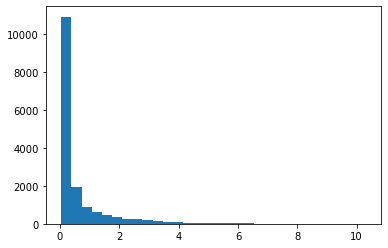

In [68]:
plt.hist(abs(data_reduced["fitness"]), bins = 30);

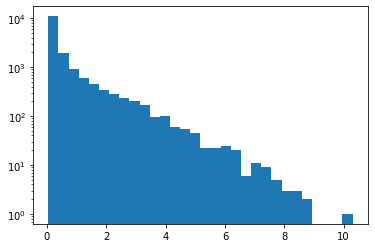

In [69]:
plt.hist(abs(data_reduced["fitness"]), bins = 30, log=True);

In [70]:
# filter all genes out where no sgRNA exceeds fitness effect > 1 in any condition
list_max_fitness = data_reduced.groupby("sgRNA_target")["fitness"].max()

In [71]:
list_max_fitness = list_max_fitness[abs(list_max_fitness) > 1]

In [72]:
data_reduced = data_reduced.reset_index().merge(list_max_fitness, on = "sgRNA_target")
#data_reduced = data_reduced.query('sgRNA_correlation > 0.5')
data_reduced.head(5)

,sgRNA_target,sgRNA,sgRNA_position,sgRNA_correlation,sgRNA_efficiency,fitness_x,fitness_y
0,Era,Era|10,10.0,0.981797,0.308089,0.974606,3.522669
1,Era,Era|25,25.0,0.972385,0.622677,1.861402,3.522669
2,Era,Era|39,39.0,0.975454,0.218752,0.885958,3.522669
3,Era,Era|64,64.0,0.976020,0.290091,0.907332,3.522669
4,Era,Era|76,76.0,0.610723,1.000000,3.522669,3.522669


### Task 2: Scale and bin target variable

Target variable is sgRNA efficiency, a relative score between 0 (no effect on fitness) and 1 (maximum effect on fitness).
Scaling can therefore be omitted.

- if target variable is taken as is, the ML problem becomes a regression problem
- if target variable is binned into e.g. 5 bins of width 0.2, the problem becomes a classification problem


In [112]:
list_bins = ["0-low", "1-med", "2-high"]
data_reduced["efficiency_binned"] = pd.cut(data_reduced["sgRNA_efficiency"], 3, labels = list_bins)

In [74]:
data_reduced["sgRNA_efficiency"]

0       0.308089
1       0.622677
2       0.218752
3       0.290091
4       1.000000
          ...   
6391    1.000000
6392    0.030921
6393    0.100192
6394    0.022564
6395    0.047291
Name: sgRNA_efficiency, Length: 6396, dtype: float64

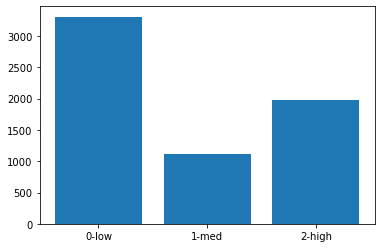

In [75]:
data_bin_sum = data_reduced.groupby("efficiency_binned").size()
plt.bar(x = data_bin_sum.index, height=data_bin_sum);

### Task 3: Prepare feature matrix

- Alignment to left (5') or right (3') end, because sgRNA length varies
- sgRNAs have variable length. Need to trim and/or pad them to a common length
- One hot encoding of sgRNA sequences

In [76]:
# filter fasta df to only sgRNAs that show an effect (common set with data)
fasta_df_reduced = pd.merge(fasta_df, data_reduced, how = 'inner', on = 'sgRNA')
print(min(fasta_df_reduced.seq_len), max(fasta_df_reduced.seq_len))

17 22


In [77]:
# align seq by inverting and optionally trimming and padding with N
def align_and_pad(seq, n_max = 25):
    inv_seq = seq.reverse_complement().complement()
    len_seq = len(inv_seq)
    if len_seq < n_max:
        inv_seq = inv_seq + "N"*(n_max-len_seq)
    elif len_seq > n_max:
        inv_seq = inv_seq[ : n_max]
    return(inv_seq)
    
# test inversion and padding
print(align_and_pad(fasta_df_reduced.seq[0], n_max = 20))

GCCCAGTGGCGGCTGTANNN


In [78]:
# apply to all sgRNAs
fasta_df_reduced["seq_inv"] = [align_and_pad(i, n_max = 22) for i in fasta_df_reduced.seq]

**Shape of the data as input for scikit learn**

- data is always a 2D array, shape (n_samples, n_features)
- features should be **one hot encoded**: all cateogrical variables are spread to an list/array with binary encoding (0 OR 1) for yes and no

In [79]:
def onehot(s):
    z = []
    for nt in str(s):
        if not nt in "AaCcGgTtNn":
            print("Non-ATGCU character: " + nt)
            raise Exception
        if nt in "Aa": z.append(1)
        else: z.append(0)
        if nt in "Cc": z.append(1)
        else: z.append(0)
        if nt in "Gg": z.append(1)
        else: z.append(0)
        if nt in "Tt": z.append(1)
        else: z.append(0)
        if nt in "Nn": z.append(1)
        else: z.append(0)
    return(z)

In [80]:
fasta_df_reduced["seq_onehot"] = fasta_df_reduced.seq_inv.apply(onehot)

- finally turn pd.Series/DF into an array with dimensions n_observations x n_features
- also turn target variable into an array of length n_observations

In [81]:
array_fasta = np.array(fasta_df_reduced.seq_onehot.to_list())
array_target = fasta_df_reduced.efficiency_binned.to_numpy()

- split into training and validation set (80%/20%)

In [82]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(array_fasta, array_target, test_size = 0.25)

In [83]:
for i in [x_train, x_test, y_train, y_test]:
    print(len(i))

4797
1599
4797
1599


## Model 1: Support vector machine

Some useful advice from the scikit-learn page

- Avoiding data copy: Data passed to certain methods will be copied before calling the underlying C implementation. Check if numpy array is C-contiguous by inspecting its flags attribute
- Kernel cache size: has a strong impact on run times for larger problems. If you have enough RAM available, increase cache_size to a higher value
- Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it
- Larger C values will take more time to train, sometimes up to 10 times longer
- SVM algorithms are not scale invariant, so it is highly recommended to scale your data (scale all features to [0,1] or [-1,+1]. This was done in our example.
- Kernel functions: can be  one of linear (most simple), polynomial (`degree`, `coef0`), rbf (`gamma` > 0), sigmoid (`coef0`)### SVM with RBF kernel

### SVM with linear or RBF kernel

In [84]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [85]:
param_grid = {'C': [0.5, 0.75, 1, 1.5], 'kernel': ['rbf', 'linear'], 'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5]}
SVM = svm.SVC()
SVM_tune = GridSearchCV(SVM, param_grid)
SVM_tune.fit(x_train[ : 1000], y_train[ : 1000])

SVM_tune_best = SVM_tune.cv_results_["rank_test_score"] == 1
SVM_tune_best = SVM_tune.cv_results_["params"][np.where(SVM_tune_best)[0][0]]
print(SVM_tune_best)

{'C': 1.5, 'gamma': 0.1, 'kernel': 'rbf'}


In [86]:
SVM = svm.SVC(**SVM_tune_best, probability = True, class_weight = "balanced")
SVM_fit = SVM.fit(x_train, y_train)
# predict class for each feature vector of training data
y_pred = SVM_fit.predict(x_test)
# predict class probability for each feature vector of training data (optional)
#SVM_fit.predict_proba(x_test)

- test predictive power of the model
- predict classes of validation data set and make confusion matrix

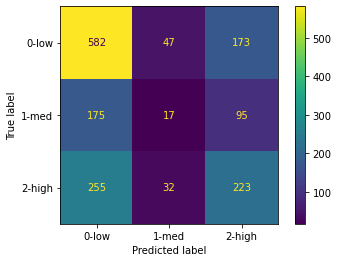

In [87]:
# x-axilogomakerredictions; y-axis: ground truth
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
SVM_cm = confusion_matrix(y_test, y_pred, labels = SVM_fit.classes_)
SVM_cmplot = ConfusionMatrixDisplay(SVM_cm, display_labels = SVM_fit.classes_)
SVM_cmplot.plot()

## Model 2: Random forest or gradient boosting machine

- Both model types decision tree based, RF with global tree refinement, GBM with local iterative refinement
- Fully tractable models: not only prediction of classes, but also feature importance
- Very important aspect of our question: Which positions/nucleotides of the sgRNA are particularly important?
- This question is almost more important than prediciting quality of sgRNAs, as it can be used to derive generalized rules

## Logos to visualize sequence motifs

- logos are visualizations for nucleotide probability or prevalence of a set of aligned sequences
- can use the python package `logomaker` installed with `pip install logomaker`
- separate logos for low, (medium), high efficiency sgRNAs

In [88]:
import logomaker

In [132]:
# function to take a pd.Series with sequences as input and plot a logo
def plot_logo(data, to_type = 'weight', ignore = 'N', title = ''):
    data_str = [str(i) for i in data]
    data_logo = logomaker.alignment_to_matrix(
        data_str, to_type = to_type,
        characters_to_ignore = ignore)
    logo = logomaker.Logo(
        data_logo,
        shade_below = 0.5,
        fade_below = 0.5,
        color_scheme = 'colorblind_safe'
    )
    logo.ax.set_ylim([-0.85, 0.6])
    logo.ax.text(0, 0.65, title,fontsize = 14)

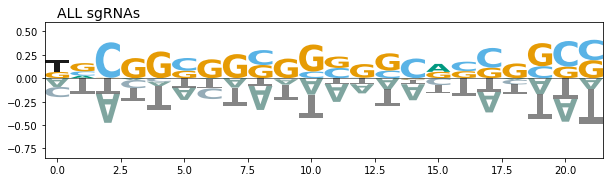

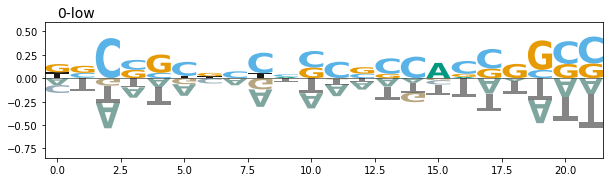

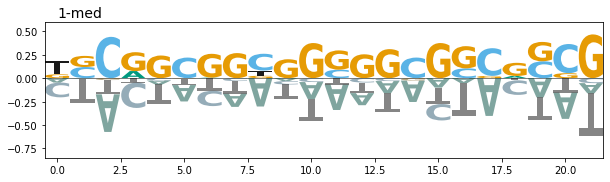

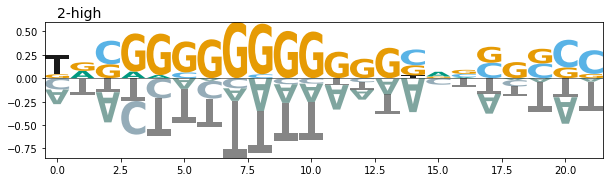

In [133]:
# Logo for ALL sgRNAs combined
plot_logo(fasta_df_reduced.seq_inv, title = 'ALL sgRNAs')

# Logo for LOW EFIICIENCY sgRNAs
for i in list_bins:
    plot_logo(
        data = fasta_df_reduced.query('efficiency_binned == "' + i + '"').seq_inv,
        title = i)